In [2]:
from qrel_reconstruction import *
import numpy as np

In [3]:
numeric_system_instructions = """
Grade how relevant a passage is to a given query on a scale of 0-3 where:
  0 - Irrelevant: The passage has nothing to do with the query.
  1 - Related: The passage seems related to the query but does not answer it.
  2 - Highly relevant: The passage has some answer for the query, but the answer may be a bit unclear, or hidden amongst extraneous information.
  3 - Perfectly relevant: The passage is dedicated to the query and contains the exact answer with no additional information.

Requests will come in the following form:
QUERY: {The users query}
DOCUMENT: {The users passage}

Your answer should take the following form:
RELEVANCY: {Relevancy score}"""

step_by_step_system_instructions = """
Grade how relevant a passage is to a given query on a scale of 0-3 where:
  0 - Irrelevant: The passage has nothing to do with the query.
  1 - Related: The passage seems related to the query but does not answer it.
  2 - Highly relevant: The passage has some answer for the query, but the answer may be a bit unclear, or hidden amongst extraneous information.
  3 - Perfectly relevant: The passage is dedicated to the query and contains the exact answer with no additional information.

Requests will come in the following form:
QUERY: {The users query}
DOCUMENT: {The users passage}

Your answer should take the following form:
RELEVANT INFO: {Summary of information in the passage that is relevant to the query, if any}
IRRELEVANT INFO: {Summary of information in the passage is NOT relevant to the query, if any}
RELEVANCY: {Relevancy score}"""

numeric_symetrical_system_instructions = """
Grade how relevant a passage is to a given query on a scale of -3 to 3 where:
  -3 - Irrelevant: The passage has nothing to do with the query.
  0 - Borderline relevant: The passage seems related to the query but does not answer it.
  3 - Perfectly relevant: The passage is dedicated to the query and contains the exact answer with no additional information.

Requests will come in the following form:
QUERY: {The users query}
DOCUMENT: {The users passage}

Your answer should take the following form:
RELEVANCY: {Relevancy score}"""

numeric_system_instructions_reversed = """
Grade how relevant a passage is to a given query on a scale of 0-3 where:
  3 - Perfectly relevant: The passage is dedicated to the query and contains the exact answer with no additional information.
  2 - Highly relevant: The passage has some answer for the query, but the answer may be a bit unclear, or hidden amongst extraneous information.
  1 - Related: The passage seems related to the query but does not answer it.
  0 - Irrelevant: The passage has nothing to do with the query.

Requests will come in the following form:
QUERY: {The users query}
DOCUMENT: {The users passage}

Your answer should take the following form:
RELEVANCY: {Relevancy score}"""

scaled_numeric_system_instructions = """
Grade how relevant a passage is to a given query on a scale of 1-10.

Requests will come in the following form:
QUERY: {The users query}
DOCUMENT: {The users passage}

Your answer should take the following form:
RELEVANCY: {Relevancy score}"""

phrase_system_instructions = """
Determine the relevancy of a query to a given passage using the given scale:
  Irrelevant: The passage has nothing to do with the query.
  Related: The passage seems related to the query but does not answer it.
  Highly relevant: The passage has some answer for the query, but the answer may be a bit unclear, or hidden amongst extraneous information.
  Perfectly relevant: The passage is dedicated to the query and contains the exact answer with no additional information.

Requests will come in the following form:
QUERY: {The users query}
DOCUMENT: {The users passage}

Your answer should take the following form:
RELEVANCY: {Relevancy}"""

simple_yn_system_instructions = """Instruction: Indicate if the passage is relevant for the question."""

explained_yn_system_instructions = """You are an expert assessor making TREC relevance judgments. You will be given a TREC topic and a portion of a document. If any part of the document is relevant to the topic, answer “Yes”. If not, answer “No”. Remember that the TREC relevance condition states that a document is relevant to a topic if it contains information that is helpful in satisfying the user's information need described by the topic. A document is judged relevant if it contains information that is on-topic and of potential value to the user."""

In [4]:
# Run this cell to load dataset from csv if avialable. Otherwise, download and parse
msmarco_passage_v2 = load_dataset("data/msmarco-passage-v2-original.csv", "msmarco-passage-v2/trec-dl-2021")

In [1]:
# Run zero-shot reversed experiments
run_experiment("gpt3.5-reversed", "gpt-3.5-turbo-0613", numeric_system_instructions_reversed, 0, msmarco_passage_v2, max_tokens=8, temperature=0)

NameError: name 'run_experiment' is not defined

In [8]:
# Run zero-shot on simple yes or no prompt
run_experiment("gpt3.5-zeroshot-yn", "gpt-3.5-turbo-0613", simple_yn_system_instructions, 0, msmarco_passage_v2, max_tokens=7, temperature=0, parser=yn_parser, max_generated=1000)

Done!


[Text(0.5, 23.52222222222222, 'Actual'),
 Text(50.722222222222214, 0.5, 'Predicted')]

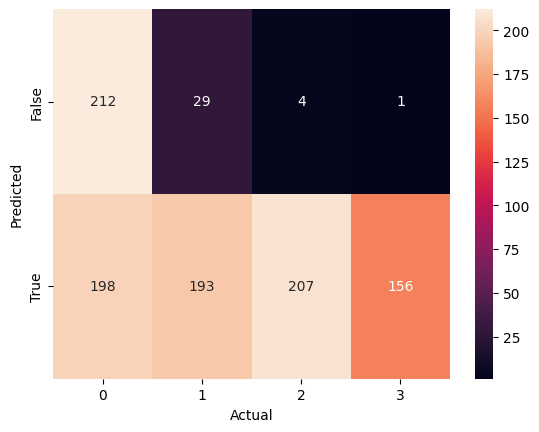

In [44]:
generated_data = load_experiments("Data/gpt3.5-zeroshot-yn.csv", msmarco_passage_v2)

grade_labels = [0, 1, 2, 3]
yn_labels = {False: 0, True: 1}

relavancy_test = generated_data.loc[~pd.isna(generated_data["Relevance Predicted"]),
                                 ("Relevance Actual", "Relevance Predicted")]

label_matrix = np.zeros((len(yn_labels), len(grade_labels)))

for ((actual, predicted), count) in relavancy_test.value_counts().items(): 
    label_matrix[yn_labels[predicted], actual] = count

label_matrix = pd.DataFrame(label_matrix, index=yn_labels.keys(), columns=grade_labels)
sn.heatmap(label_matrix, annot=True, fmt=".0f", ).set(xlabel="Actual", ylabel="Predicted")

In [5]:
# Run zero-shot on symetrical
run_experiment("gpt3.5-symetrical", "gpt-3.5-turbo-0613", numeric_symetrical_system_instructions, 0, msmarco_passage_v2, max_tokens=8, temperature=0, max_generated=1000)

Done!


In [6]:
# Run zero-shot on step by step prompt
run_experiment("gpt3.5-step_by_step", "gpt-3.5-turbo-0613", step_by_step_system_instructions, 0, msmarco_passage_v2, max_tokens=200, temperature=0, parser=number_parser, max_generated=1000)

Done!


              precision    recall  f1-score   support

           0       0.92      0.30      0.45       407
           1       0.24      0.28      0.26       216
           2       0.34      0.62      0.44       210
           3       0.42      0.60      0.49       156

    accuracy                           0.41       989
   macro avg       0.48      0.45      0.41       989
weighted avg       0.57      0.41      0.41       989



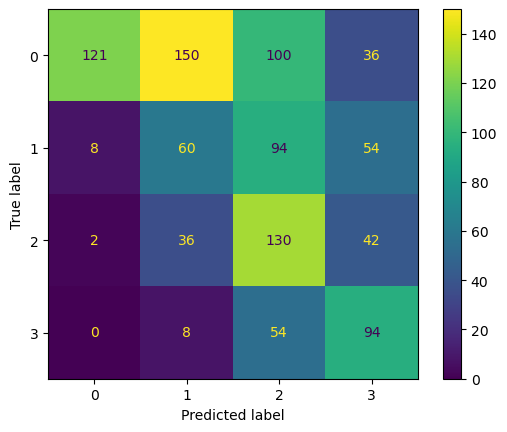

In [9]:
# Display metrics
step_by_step_predictions = load_experiments("Data/gpt3.5-step_by_step.csv", msmarco_passage_v2)
prediction_metrics(step_by_step_predictions)

In [ ]:
# Run zero-shot on scaled (1-10) numeric prompt
run_experiment("gpt3.5-scaled", "gpt-3.5-turbo-0613", scaled_numeric_system_instructions, 0, msmarco_passage_v2, max_tokens=8, temperature=0, max_generated=1000)

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Actual')]

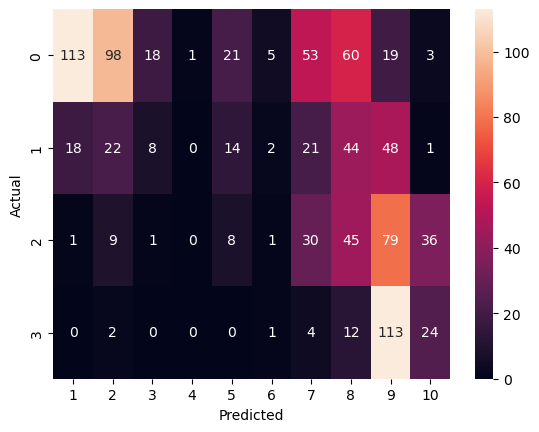

In [6]:
generated_data = load_experiments("Data/gpt3.5-scaled.csv", msmarco_passage_v2)

grade_labels = [0, 1, 2, 3]
scaled_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


relavancy_test = generated_data.loc[~pd.isna(generated_data["Relevance Predicted"]),
                                 ("Relevance Actual", "Relevance Predicted")]

label_matrix = np.zeros((len(grade_labels), len(scaled_labels)))

for ((actual, predicted), count) in relavancy_test.value_counts().items(): 
    label_matrix[actual, int(predicted-1)] = count

label_matrix = pd.DataFrame(label_matrix, columns=scaled_labels,index=grade_labels)
sn.heatmap(label_matrix, annot=True, fmt=".0f", ).set(xlabel="Predicted", ylabel="Actual")

In [5]:
# Run zero-shot on phrase-based prompt
run_experiment("gpt3.5-zeroshot-phrase", "gpt-3.5-turbo-0613", phrase_system_instructions, 0, msmarco_passage_v2, max_tokens=20, temperature=0, parser=word_parser, max_generated=1000)

1000 -- Actual: 0, Predicted: Irrelevant
Done!


              precision    recall  f1-score   support

           0       0.87      0.29      0.43       407
           1       0.24      0.44      0.31       216
           2       0.30      0.48      0.37       210
           3       0.40      0.31      0.35       156

    accuracy                           0.37       989
   macro avg       0.45      0.38      0.36       989
weighted avg       0.54      0.37      0.38       989



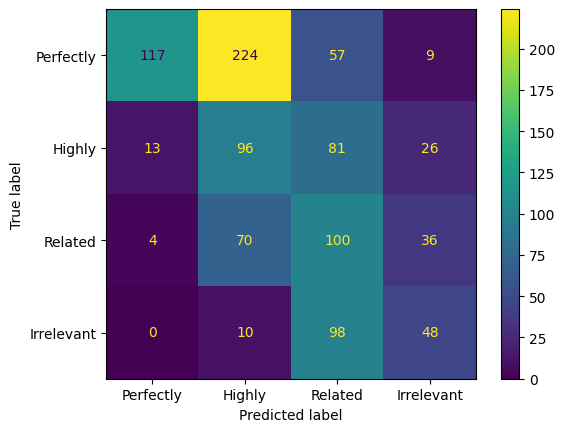

In [22]:
generated_data = load_experiments("Data/gpt3.5-zeroshot-phrase.csv", msmarco_passage_v2)

grade_labels = [0, 1, 2, 3]
phrase_labels = {"Perfectly":3, "Highly":2, "Related": 1, "Irrelevant": 0}

relavancy_test = generated_data.loc[~pd.isna(generated_data["Relevance Predicted"]),
                                 ("Relevance Actual", "Relevance Predicted")].to_numpy()

actual = list(relavancy_test[:, 0])
predicted = list(map(lambda x: phrase_labels[x], relavancy_test[:, 1]))

print(classification_report(actual, predicted, labels=grade_labels))

ConfusionMatrixDisplay(confusion_matrix(actual, predicted, labels=grade_labels), display_labels=phrase_labels.keys()).plot()

In [5]:
# Run zero-shot on explained yes or no prompt
run_experiment("gpt3.5-zeroshot-yn-explained", "gpt-3.5-turbo-0613", explained_yn_system_instructions, 0, msmarco_passage_v2, max_tokens=7, temperature=0, parser=yn_parser, max_generated=1000)

Done!


[Text(0.5, 23.52222222222222, 'Actual'),
 Text(50.722222222222214, 0.5, 'Predicted')]

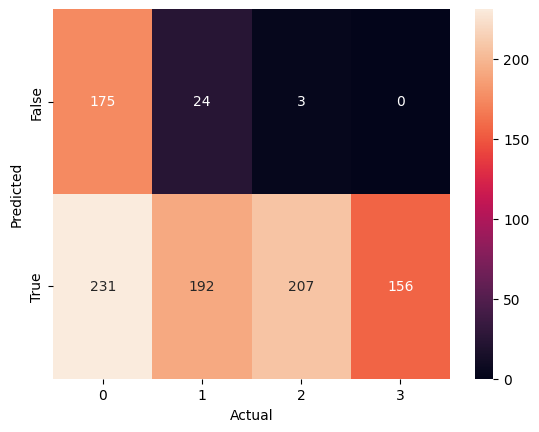

In [7]:
generated_data = load_experiments("Data/gpt3.5-zeroshot-yn-explained.csv", msmarco_passage_v2)

grade_labels = [0, 1, 2, 3]
yn_labels = {False: 0, True: 1}

relavancy_test = generated_data.loc[~pd.isna(generated_data["Relevance Predicted"]),
                                 ("Relevance Actual", "Relevance Predicted")]

label_matrix = np.zeros((len(yn_labels), len(grade_labels)))

for ((actual, predicted), count) in relavancy_test.value_counts().items(): 
    label_matrix[yn_labels[predicted], actual] = count

label_matrix = pd.DataFrame(label_matrix, index=yn_labels.keys(), columns=grade_labels)
sn.heatmap(label_matrix, annot=True, fmt=".0f", ).set(xlabel="Actual", ylabel="Predicted")

In [ ]:
# Run zero-shot experiments
run_experiment("gpt3.5-zeroshot", "gpt-3.5-turbo-0613", numeric_system_instructions, 0, msmarco_passage_v2, max_tokens=7, temperature=0)

              precision    recall  f1-score   support

           0       0.85      0.51      0.64      2252
           1       0.33      0.19      0.24      1776
           2       0.31      0.37      0.34      1508
           3       0.26      0.76      0.38       705

    accuracy                           0.41      6241
   macro avg       0.44      0.46      0.40      6241
weighted avg       0.51      0.41      0.43      6241



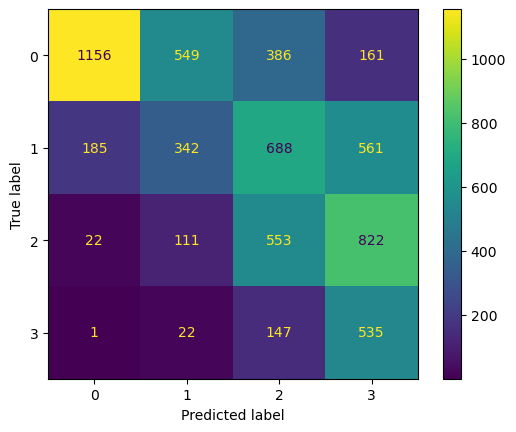

In [7]:
# Display metrics
zero_shot_predictions = load_experiments("Data/gpt3.5-zeroshot.csv", msmarco_passage_v2)
prediction_metrics(zero_shot_predictions)

In [6]:
# Run few-shot experiments
run_experiment("gpt3.5-fewshot", "gpt-3.5-turbo-0613", numeric_system_instructions, 4, msmarco_passage_v2, max_tokens=8, temperature=0, max_generated=1000)

Done!


              precision    recall  f1-score   support

           0       0.83      0.29      0.42       407
           1       0.26      0.40      0.31       216
           2       0.35      0.35      0.35       210
           3       0.40      0.78      0.53       156

    accuracy                           0.40       989
   macro avg       0.46      0.45      0.40       989
weighted avg       0.54      0.40      0.40       989



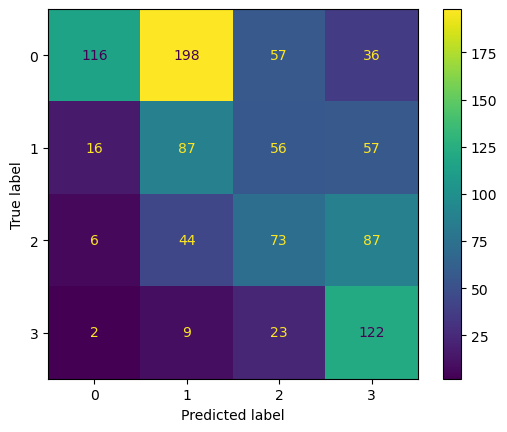

In [6]:
# Display metrics
few_shot_predictions = load_experiments("Data/gpt3.5-fewshot.csv", msmarco_passage_v2)
prediction_metrics(few_shot_predictions)

In [12]:
# Combine all of the experiments into a single file
combined_dataset = pd.concat([msmarco_passage_v2, zero_shot_predictions['Relevance Predicted'], zero_shot_reversed_predictions['Relevance Predicted'], few_shot_predictions['Relevance Predicted'], few_shot_reversed_predictions['Relevance Predicted']], axis=1)
combined_dataset = combined_dataset.set_axis(["QueryID", "DocumentID", "Query", "Document", "Actual", "Is Example", "Zeroshot", "Zeroshot Reversed", "Fewshot", "Fewshot Reversed"], axis=1)
combined_dataset.to_csv(Path('data/msmarco-passage-v2-reconstruction.csv'))